In [1]:
import os
os.chdir("/Users/benjaminangelard/Thesis_Recommender_system")

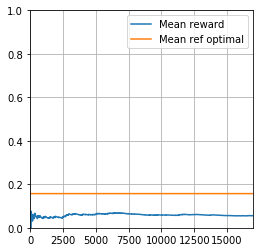

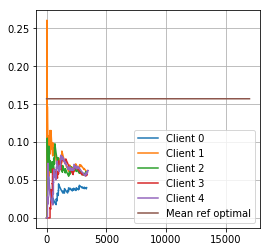

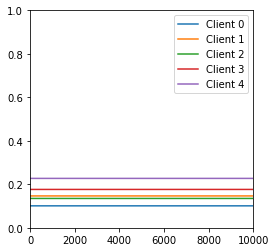

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython.display import clear_output
from Environment.BanditEnvironment_stationary import BanditEnvironment as env_generator
from Tools import Logger
n_feature_item = 3
n_feature_client = 3
range_price = 10
range_color = 5
n_client = 5
n_item = 5
size_embedding_client = 2
size_embedding_item = 2
hidden_layer_size = 128


class ActorCritic2(nn.Module) :
    def __init__(self) :
        super(ActorCritic2, self).__init__()
        self.embedder_item = nn.Embedding(n_item, size_embedding_item)

        self.embedder_client = nn.Embedding(n_client, size_embedding_client)
        self.dense_item = nn.Linear(size_embedding_client, hidden_layer_size)
        self.dense_client = nn.Linear(size_embedding_item, hidden_layer_size)
        # Test concatenation apres concatenation
        self.probability = nn.Linear(hidden_layer_size, 1)
        self.value = nn.Linear(hidden_layer_size, 1)

    # CONTENT BASED x : [client_properties ; item_properties]
    # Comment gerer multi item pour l'embedding
    # Pas concatener car probleme d'ordre
    # Dot product item et client embedding
    # Commence par non content based - Seulement ID et embedding

    # Non content based : Client_ID - ListItem
    def forward(self, x) :
        # print("X : ",x)
        client_ID = torch.tensor(x[0], dtype = torch.long)
        items_lists = x[1]
        items_list_ID = torch.tensor([item.get_id for item in items_lists])
        embeds_client = self.embedder_client(client_ID)  # .view((1, -1))
        embeds_items = self.embedder_item(items_list_ID)  # .view((1, -1))
        out_client = F.relu(self.dense_client(embeds_client))
        out_item = F.relu(self.dense_item(embeds_items))
        # print("Out client debse", out_client.shape)
        # print("Out item dense", out_item.shape)

        out = out_client * out_item
        # print("Output size with mult", out.shape)
        #  print(out_client.shape, out_item.shape, out.shape)
        probs = self.probability(out)
        value = self.value(out)
        # print("Probs shape : ", probs.shape)
        # print("Value shape : ", value.shape)
        return F.softmax(probs, dim = 0), value


class Runner() :
    def __init__(self, env, gamma = 0.99, n_episode = 10000) :
        self.model = ActorCritic2()
        self.env = env
        self.optimizer = optim.Adam(self.model.parameters(), lr = 1e-2)
        self.memory = []
        self.gamma = gamma
        self.log_delay = 50
        self.n_episode = n_episode
        self.batch_size = 32
        self.epsilon = np.finfo(np.float32).eps.item()
        self.logger = Logger.Logger(n_client, env)
    def select_action(self, state) :
        probs, value = self.model(state)
        # On recupere une proba 5x5
        # Theorie : Utiliser la repartition de la ligne avec meilleure value ?
        #  print("Probs and value shape ", probs.shape, value.shape, torch.argmax(value))
        #  print(probs)
        m = Categorical(probs[torch.argmax(value)])
        action = m.sample()
        self.memory.append((m.log_prob(action), value[action]))
        return action.item()

    def replay(self, rewards_log) :
        memorized = self.memory
        policy_loss = []
        value_loss = []
        rewards = []
        R = 0
        for rew in rewards_log[: :-1] :  # Compute reward for trajectoire
            R = rew + self.gamma * R
            rewards.append(R)
        rewards.reverse()
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + self.epsilon)  # Normalize
        for (log_prob, value), r in zip(memorized, rewards) :
            Advantage = r - value.item()  # Advantage estimate
            policy_loss.append(-log_prob * Advantage)  # Policy gradient loss
            value_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))  # Minimize R_T - prediction
        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()  # Remove gradient, maintain loss value
        loss.backward()
        self.optimizer.step()
        self.memory = []

    def run(self) :
        print(self.model)
        rewards = []
        cumulator = []
        ep_reward = 0
        last_reward = 0
        ep_reward_cumul = []
        mean_delta = []
        mean_log = []
        delay = 1000
        for i_episode in range(self.n_episode) :
            client_id, items = self.env.reset()
            ep_reward_cumul.append(ep_reward)
            mean_delta.append(np.mean(cumulator))
            mean_log.append(np.mean(ep_reward_cumul))

            clear_output(True)
            self.logger.plot()
            

            ep_reward = 0
            for t in range(delay) :  # Collect trajectoire
                # state = [client.get_properties[1], list_item, client_id]
                state = [client_id, items]
                action = self.select_action(state)
                client_id, items, reward = env.step_mono_recommendation(action)
                if reward > 0 :
                    delta = t + i_episode * delay - last_reward
                    cumulator.append(delta)

                    last_reward = t + i_episode * delay
                ep_reward += reward
                rewards.append(reward)
                self.logger.add_reward_client(reward, client_id)
            self.replay(rewards)
            rewards = []
            if i_episode % self.log_delay == 0 :
                print("Episode {} with reward : {}".format(i_episode, ep_reward))


if __name__ == '__main__' :
    env = env_generator(n_client = n_client, n_item = n_item, nb_color = range_color, range_price = range_price)
    torch.manual_seed(42)
    runner = Runner(env)
    runner.run()


In [ ]:
runner.logger.plot_opti_per_client()

In [ ]:
plt.subplot(111)
axis = plt.gca()
axis.set_ylim([0, 1])

for client_index in range(5):
    plt.scatter(y = runner.logger.log_opti[client_index], x=range(len(runner.logger.log_opti[client_index])), label = "Client {}".format(client_index))
plt.legend()

In [ ]:
plt.subplot(111)
axis = plt.gca()
axis.set_ylim([0, 1])

for client_index in range(5):
    plt.plot(runner.logger.log_opti[client_index][:10], label = "Client {}".format(client_index))
plt.legend()

In [ ]:
runner.env.get_indicator()

In [ ]:
for client in runner.env.list_client:
    print(client.center_of_price)

In [ ]:
runner.env.list_client[4]._taste

In [ ]:
for item in runner.env.list_items:
    print(item.get_properties[:2])